# Transport Equations

[Transport (or continuity) equations](https://en.wikipedia.org/wiki/Continuity_equation) are some of the simplest and most useful kind of PDEs encountered in physics. They are used to model the transport / movement of some (continuous) quantity.

## Classical Transport Equation

The transport equation is one of the "simplest" partial differential equations, defined by
$$
    u_t + b \cdot \nabla u = 0 \text{ in } \symbb{R}^n \times (0, \infty)
$$
for a fixed vector $b \in \symbb{R}^n$.

We will compute the solution for an instance of this problem numerically.

In [1]:
using ModelingToolkit
using LinearAlgebra
using DomainSets

# Parameters, variables, and derivatives
@parameters t x y
@variables u(..)

Dt = Differential(t)
Dx = Differential(x)
Dy = Differential(y)

∇(u) = [Dx(u), Dy(u)]

# 2D PDE and boundary conditions
b = [1.0, 2.0]

equation = Dt(u(t, x, y)) + b ⋅ ∇(u(t, x, y)) ~ 0

stddev = 0.1
boundary_conditions = [u(0, x, y) ~ exp(-(x^2 + y^2)/(stddev^2))]

# Space and time domains
domains = [
    t ∈ Interval(0.0, 3.0),
    x ∈ Interval(-3.0, 3.0),
    y ∈ Interval(-3.0, 3.0)
]

# PDE system
@named pde_system = PDESystem(
    equation, boundary_conditions, domains, 
    # Independent variables
    [t, x, y], 
    # Dependent variables
    [u(t, x, y)]
)

PDESystem
Equations: Equation[2.0Differential(y)(u(t, x, y)) + Differential(x)(u(t, x, y)) + Differential(t)(u(t, x, y)) ~ 0]
Boundary Conditions: Equation[u(0, x, y) ~ exp(99.99999999999999(-(x^2) - (y^2)))]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 3.0), Symbolics.VarDomainPairing(x, -3.0 .. 3.0), Symbolics.VarDomainPairing(y, -3.0 .. 3.0)]
Dependent Variables: Num[u(t, x, y)]
Independent Variables: Num[t, x, y]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [2]:
using MethodOfLines

# Method of lines discretization
N = 32
order = 2
discretization = MOLFiniteDifference([x => N, y => N], t)

MOLFiniteDifference{MethodOfLines.CenterAlignedGrid, MethodOfLines.ScalarizedDiscretization}(Dict{Num, Int64}(y => 32, x => 32), t, 2, UpwindScheme(1), MethodOfLines.CenterAlignedGrid(), true, false, MethodOfLines.ScalarizedDiscretization(), true, Any[], Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}())

In [3]:
# Convert the PDE problem into an ODE problem
ode_problem = discretize(pde_system, discretization);

In [4]:
# Solve ODE problem
using OrdinaryDiffEq
solution = solve(ode_problem, Tsit5(), saveat=0.1)
solution.retcode

ReturnCode.Success = 1

In [5]:
# Plot results
discrete_x = solution[x]
discrete_y = solution[y]
discrete_t = solution[t]
solution_u = solution[u(t, x, y)]
;

[ Info: Saved animation to /Users/gabrielmajeri/Projects/Doctorat/PhysicsSimulations/notebooks/tmp.gif


Plots.AnimatedGif("/Users/gabrielmajeri/Projects/Doctorat/PhysicsSimulations/notebooks/tmp.gif")
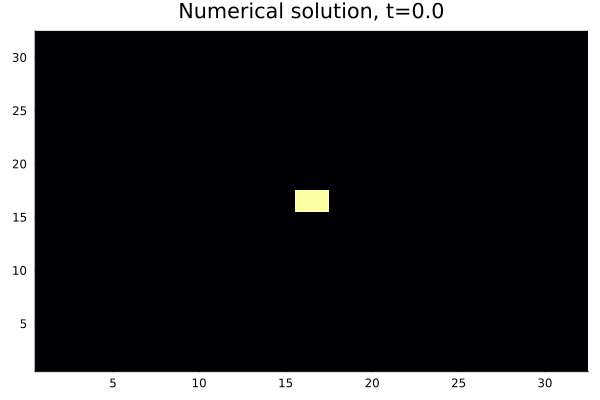

In [6]:
using Plots

default(legend = false)

@gif for i in eachindex(discrete_t)
    plt = heatmap(solution_u[i, :, :], title="Numerical solution, t=$(discrete_t[i])")
end fps=4

## Modified Transport Equation

To make things more interesting, let's add an extra term to the classical transport equation.
$$
    u_t + b \cdot \nabla u + c u = 0 \text{ in } \symbb{R}^n \times (0, \infty)
$$
for constant $b \in \symbb{R}^n$ and $c \in \symbb{R}$.

In [7]:
b = 0.5 * [2.0, 1.0]
c = 5.0

equation = Dt(u(t, x, y)) + b ⋅ ∇(u(t, x, y)) + c * u(t, x, y) ~ 0

stddev = 0.1
boundary_conditions = [u(0, x, y) ~ exp(-(x^2 + y^2)/(stddev^2))]

# Space and time domains
domains = [
    t ∈ Interval(0.0, 2.5),
    x ∈ Interval(-3.0, 3.0),
    y ∈ Interval(-3.0, 3.0)
]

# PDE system
@named pde_system = PDESystem(
    equation, boundary_conditions, domains, 
    # Independent variables
    [t, x, y], 
    # Dependent variables
    [u(t, x, y)]
)

PDESystem
Equations: Equation[5.0u(t, x, y) + 0.5Differential(y)(u(t, x, y)) + Differential(x)(u(t, x, y)) + Differential(t)(u(t, x, y)) ~ 0]
Boundary Conditions: Equation[u(0, x, y) ~ exp(99.99999999999999(-(x^2) - (y^2)))]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 2.5), Symbolics.VarDomainPairing(x, -3.0 .. 3.0), Symbolics.VarDomainPairing(y, -3.0 .. 3.0)]
Dependent Variables: Num[u(t, x, y)]
Independent Variables: Num[t, x, y]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [8]:
# Convert the PDE problem into an ODE problem
ode_problem = discretize(pde_system, discretization)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 2.5)
u0: 1024-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [9]:
# Solve ODE problem
using OrdinaryDiffEq
solution = solve(ode_problem, Tsit5(), saveat=0.1)

retcode: Success
Interpolation: Dict{Num, Interpolations.GriddedInterpolation{Float64, 3, Array{Float64, 3}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}}}
t: 26-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 1.3
 1.4
 1.5
 1.6
 1.7
 1.8
 1.9
 2.0
 2.1
 2.2
 2.3
 2.4
 2.5ivs: 3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 t
 x
 ydomain:([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5], -3.0:0.1935483870967742:3.0, -3.0:0.1935483870967742:3.0)
u: Dict{Num, Array{Float64, 3}} with 1 entry:
  u(t, x, y) => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0…

In [10]:
# Plot results
discrete_x = solution[x]
discrete_y = solution[y]
discrete_t = solution[t]
solution_u = solution[u(t, x, y)]
;

[ Info: Saved animation to /Users/gabrielmajeri/Projects/Doctorat/PhysicsSimulations/notebooks/tmp.gif


Plots.AnimatedGif("/Users/gabrielmajeri/Projects/Doctorat/PhysicsSimulations/notebooks/tmp.gif")
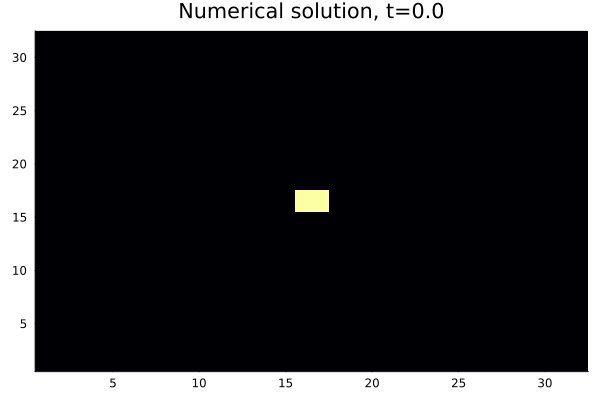

In [11]:
using Plots

default(legend = false)

@gif for i in eachindex(discrete_t)
    plt = heatmap(solution_u[i, :, :], title="Numerical solution, t=$(discrete_t[i])")
end fps=4